# Taller ASP - Daniel Crovo - Deep Learning
**Objetivos**
- Predecir los valores futuros de una serie temporal haciendo uso de técnicas de Deep Learning.
- Implementar la optimización de hiperparámetros y cuantificar el efecto a través de métricas de desempeño.

En el ámbito de la ingenierı́a eléctrica, uno de los principales desafı́os es la planificación y gestión eficiente de la producción de energı́a eléctrica. La potencia activa es una medida de la energı́a eléctrica que se consume o se produce en un sistema eléctrico en un momento dado, y su estimación precisa es esencial para garantizar que la producción de energı́a eléctrica se ajuste a la demanda en tiempo real. Además, la potencia activa es uno de los factores clave que determinan la estabilidad y la calidad de la energı́a eléctrica suministrada a los consumidores. Por lo anterior, la predicción de la potencia activa global que se espera que se consuma o produzca en las próximas 24 horas es un problema crı́tico en la planificación y gestión de la producción de energı́a eléctrica. Una solución precisa y confiable para este problema puede ayudar a mejorar la eficiencia y la estabilidad de la red eléctrica, ası́ como a reducir los costos y las emisiones de gases de efecto invernadero asociados con la producción de energı́a eléctrica.

## Preprocesamiento de los datos

In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
import os 
import numpy as np
from sklearn.metrics import mean_squared_error


data = pd.read_csv('../data/data_asp.csv')
data.head()

,Fecha,Hora,Potencia Activa Global (W)
0,16/12/2006,17:24:00,4.216
1,16/12/2006,17:25:00,5.360
2,16/12/2006,17:26:00,5.374
3,16/12/2006,17:27:00,5.388
4,16/12/2006,17:28:00,3.666


In [174]:
# Renombrar columnas y concatenar Fecha y Hora para utilizarlas como index
data.rename(columns={'Potencia Activa Global (W)':'Power'}, inplace=True) 
data['Power'] = pd.to_numeric(data['Power'], errors='coerce')
data['Datetime'] = data['Fecha'] +" "+ data['Hora']     
data['Datetime'] = pd.to_datetime(data['Datetime'], dayfirst=True)

# Se eliminan las columnas pues ya no se requieren
data.drop(['Fecha', 'Hora'], axis=1,inplace=True)
data.set_index('Datetime', inplace=True)
data.head()

,Power
Datetime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


In [175]:
train = data.loc['2006-12-16 17:24:00':'2010-01-01 00:00:00'].copy()
test = data.loc['2010-01-01 00:01:00':].copy()

In [176]:
train.shape

(1600237, 1)

In [177]:
test.shape

(475022, 1)

In [124]:
# Se verifica información básica del dataset
data.describe()

,Power
count,2.049280e+06
mean,1.091615e+00
std,1.057294e+00
min,7.600000e-02
25%,3.080000e-01
50%,6.020000e-01
75%,1.528000e+00
max,1.112200e+01


In [125]:
# Las siguientes lineas de código se utilizarn para verificar cómo están distribuidos los datos núlos

# grouped = data.groupby(by=data.index.month)
# nan = data[pd.isna(data['Power'])]
# nan = nan.fillna(1)
# nan_values = nan.groupby(by=[nan.index.month,nan.index.day,nan.index.year]).count()

data[pd.isna(data['Power'])].size

25979

Existen 25979 datos nulos, los cuales se van a reemplazar por el valor de la media.

In [178]:
#data.fillna(data['Power'].mean(), inplace=True)
train.fillna(train['Power'].mean(), inplace=True)
test.fillna(test['Power'].mean(), inplace=True)

In [127]:
# Se verifica que no queden valores nulos
data[pd.isna(data['Power'])].size

0

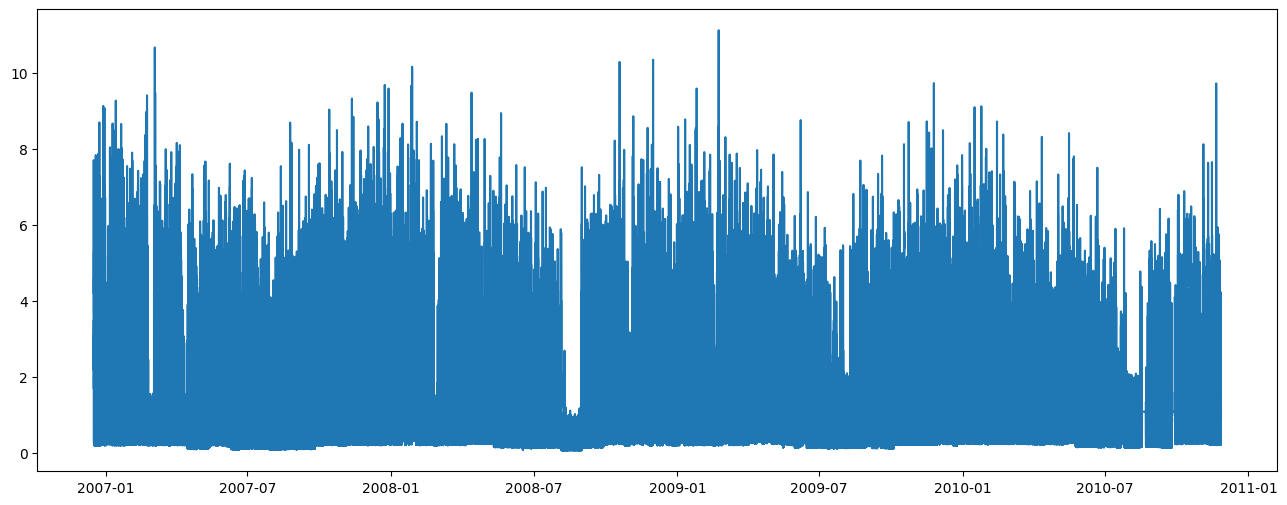

In [128]:
plt.figure(figsize=(16,6))
plt.plot(data)

Considerando que el problema consiste en predecir las siguientes 24 horas de consumo, dadas las 24 horas previas, hace sentido hacer un re-muestreo del dataset. 

In [179]:
#data_hour = data.resample('H').mean()
train_hour = train.resample('H').mean()
test_hour = test.resample('H').mean()

<Axes: xlabel='Datetime'>

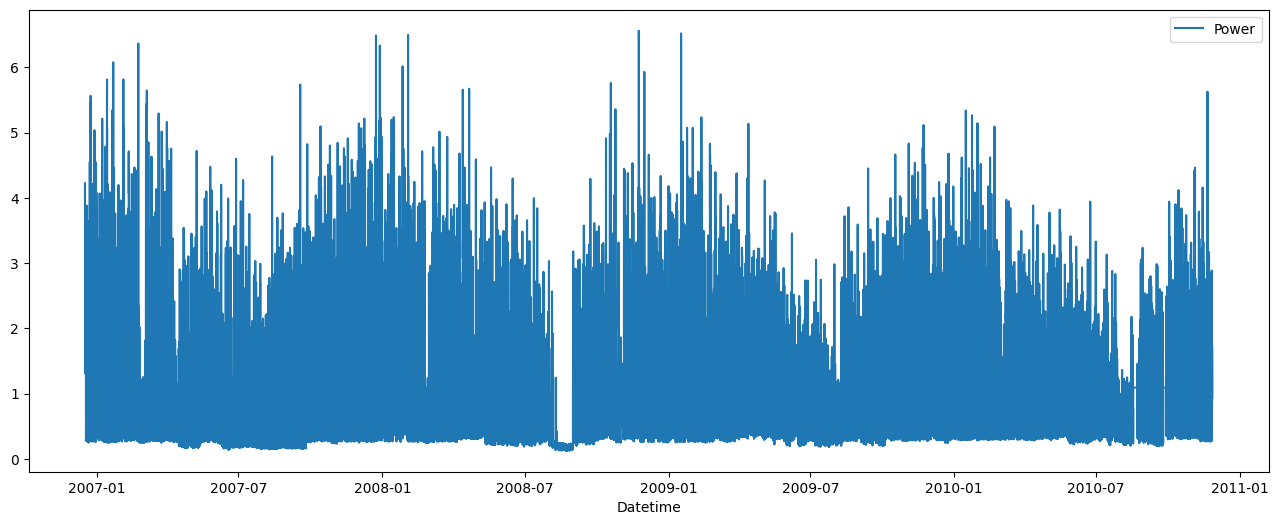

In [130]:
plt.figure(figsize=(16,6))
sns.lineplot(data_hour)

In [131]:
data_hour.head()

,Power
Datetime,
2006-12-16 17:00:00,4.222889
2006-12-16 18:00:00,3.632200
2006-12-16 19:00:00,3.400233
2006-12-16 20:00:00,3.268567
2006-12-16 21:00:00,3.056467


In [217]:
index = 0 
seq_length = 1440

scaler = MinMaxScaler()
scaler.fit(data[['Power']].values)

print(scaler.transform(data[['Power']].values))

print(scaler.inverse_transform(scaler.transform(data[['Power']].values)))

[[0.37479631]
 [0.47836321]
 [0.47963064]
 ...
 [0.0780373 ]
 [0.07767518]
 [0.07749412]]
[[4.216]
 [5.36 ]
 [5.374]
 ...
 [0.938]
 [0.934]
 [0.932]]


In [133]:
#input_seq = torch.tensor(scaler.transform(data.iloc[index:index+seq_length]['Power'].values.reshape(-1,1)))
#input_seq = torch.tensor(scaler.transform(input_seq))

In [134]:
del input_seq

In [135]:
data_hour.values.shape

(34589, 1)

In [228]:

class PowerData(Dataset): 
    def __init__(self, data_df, seq_length):
        self.data = data_df
        self.seq_length = seq_length
        self.scaler = MinMaxScaler()
        self.scaler.fit(self.data[['Power']].values)

    def __getitem__(self, index):
        
        input_seq = torch.tensor(scaler.transform(self.data.iloc[index:index+self.seq_length]['Power'].values.reshape(-1,1))).flatten()
        target = torch.tensor(scaler.transform(self.data.iloc[index+self.seq_length:index+(self.seq_length*2)]['Power'].values.reshape(-1,1))).flatten()
        
        return input_seq, target 
    def __len__(self): 
        return(len(self.data) - self.seq_length*2)
    
        

In [181]:
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super(BaselineModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        #print(x.shape)
        x, h = self.lstm(x)
        #print(x.shape)
        x = self.linear(x)

        return x

In [182]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    p_bar = tqdm(train_loader)
    model.train()

    for batch_idx, (data, target) in enumerate(p_bar):

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        p_bar.set_postfix(loss= loss.item())

In [234]:
def performance(model, device, val_loader, test_data):
    model.eval()
    #preds = np.array([0])
    #targets = np.array()
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            y = model(x)

            preds = np.concatenate(y.cpu().detach().numpy())
            targets = np.concatenate(x.cpu().detach().numpy())

    
 
    smape = (100/len(targets))*np.sum((np.abs(preds-targets))/((np.abs(targets-preds))/2))
    print(' Simetric mean absolite percentage error: ', smape)
    return preds, targets

In [235]:
# Hyperparámetros
batch_size = 32
epochs = 50
lr  = 0.001
input_size =24
output_size = 24
hidden_size = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')

train_data = PowerData(train_hour, input_size)
test_data = PowerData(test_hour, input_size)

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

model = BaselineModel(input_size, hidden_size, output_size, 1).to(device)
model.double()
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(1, epochs+1):
    train(model, device, train_loader, optimizer, criterion, epoch)

preds, truth = performance(model, device, test_loader, test_data)
mean_squared_error(truth, preds)

Training on cuda


  0%|          | 0/832 [00:00<?, ?it/s]

  0%|          | 0/832 [00:00<?, ?it/s]

  0%|          | 0/832 [00:00<?, ?it/s]

  0%|          | 0/832 [00:00<?, ?it/s]

In [233]:
test_data = PowerData(test_hour, input_size)



[[0.6709382 ]
 [0.73716982]
 [0.74660243]
 [0.70062276]
 [0.60120676]
 [0.69486998]
 [0.61962562]
 [0.50160641]
 [0.44476361]
 [0.6156159 ]]
[0.03922385 0.08172491 0.15970487 0.19420907 0.23181846 0.12223731
 0.06851349 0.04741083 0.0255628  0.01713743]
 Simetric mean absolite percentage error:  200.0


0.002458320429534854

In [87]:
#Testing size
dataset = PowerData(data_hour, 24)
input, target = dataset[dataset.__len__()]
print(input.shape, target.shape)

torch.Size([24, 1]) torch.Size([24, 1])


In [ ]:
model.